(40000, 1000)
(40000, 10)
[30.       29.138577 28.347336 27.61724  26.9408   26.311743 25.724789
 25.17544  24.659847 24.17469 ]
[40.       39.920242 39.840958 39.762142 39.683792 39.605907 39.52847
 39.45149  39.374966 39.298874]


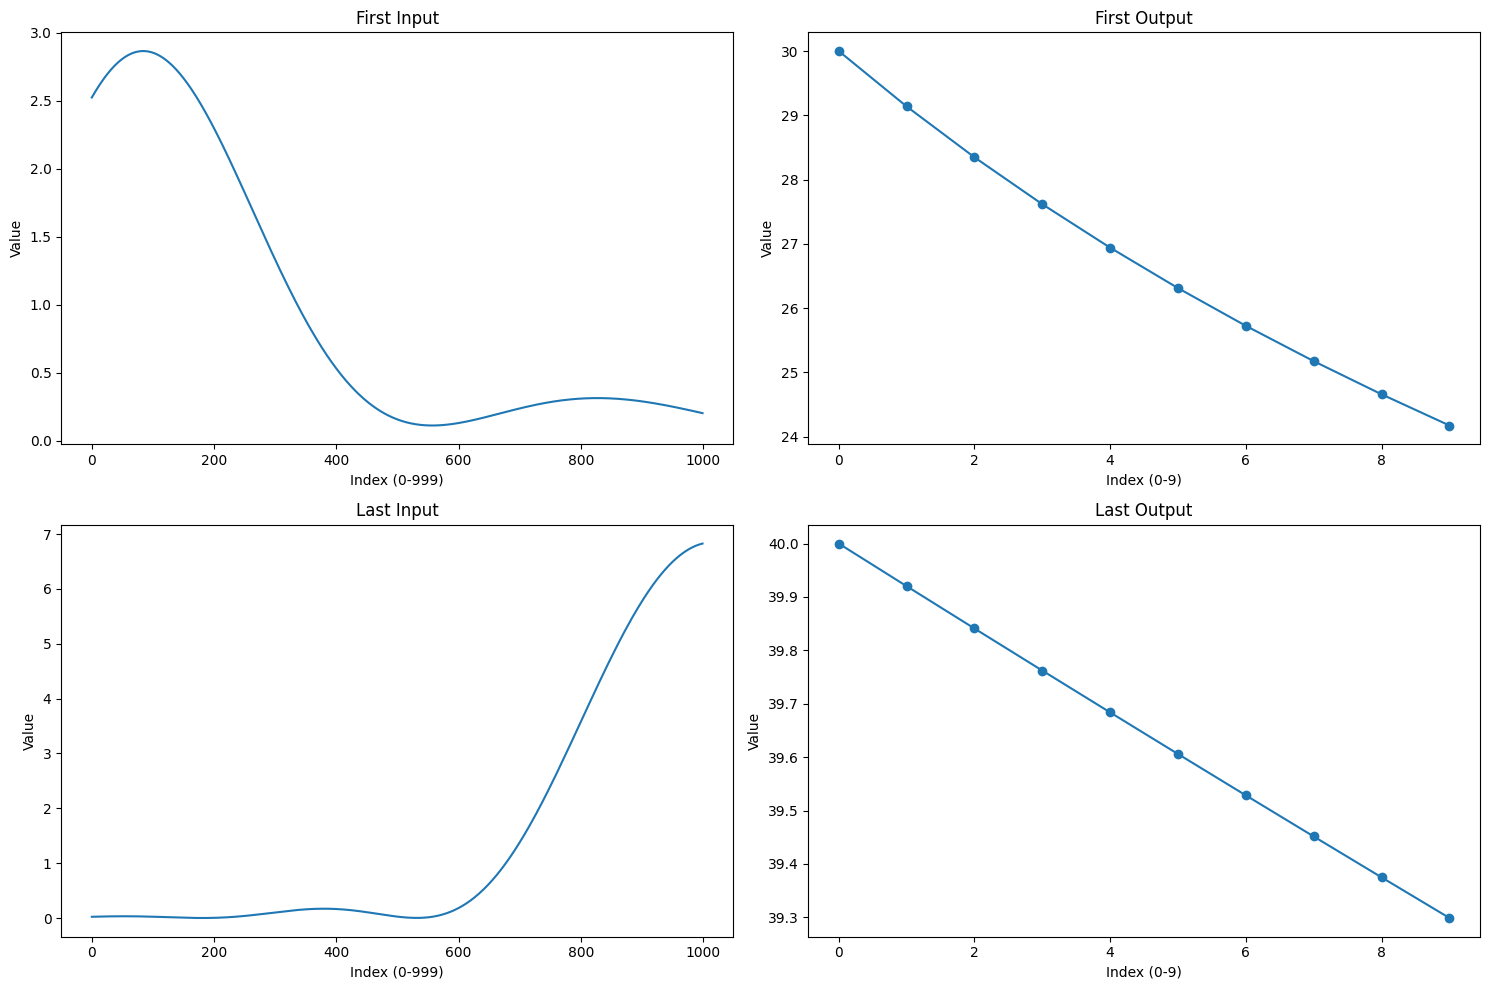

In [19]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from syuron import dataset
from workspace import path
import tensorflow as tf

filepath = path.Path("research/syuron/dataset/chirped_scaled2.tfrecord")
ds = dataset.load(filepath, 40000)
batch = next(iter(ds))
inputs, outputs = batch
print(inputs.shape)
print(outputs.shape)
# tf.data.Dataset.from_tensor_slices((inputs, outputs * 10)).save(
#     path.Path("research/syuron/dataset/chirped_scaled2.tfrecord").abs())

# 最初と最後のデータポイントを取得
first_input = inputs[0]
first_output = outputs[0]
last_input = inputs[-1]
last_output = outputs[-1]
print(first_output)
print(last_output)

# 横軸を作成
input_x = jnp.linspace(0, 999, 1000)
output_x = jnp.linspace(0, 9, 10)

# プロットを作成
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# 最初のinputをプロット
axs[0, 0].plot(input_x, first_input)
axs[0, 0].set_title('First Input')
axs[0, 0].set_xlabel('Index (0-999)')
axs[0, 0].set_ylabel('Value')

# 最初のoutputをプロット
axs[0, 1].plot(output_x, first_output, 'o-')
axs[0, 1].set_title('First Output')
axs[0, 1].set_xlabel('Index (0-9)')
axs[0, 1].set_ylabel('Value')

# 最後のinputをプロット
axs[1, 0].plot(input_x, last_input)
axs[1, 0].set_title('Last Input')
axs[1, 0].set_xlabel('Index (0-999)')
axs[1, 0].set_ylabel('Value')

# 最後のoutputをプロット
axs[1, 1].plot(output_x, last_output, 'o-')
axs[1, 1].set_title('Last Output')
axs[1, 1].set_xlabel('Index (0-9)')
axs[1, 1].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [25]:
from syuron import dataset
from syuron import mlp
from workspace import path


filepath = path.Path("research/syuron/dataset/chirped_scaled2.tfrecord")
ds = dataset.load(filepath)
final_state, final_loss = mlp.train_and_eval(
    ds,
    mlp.use_state,
    mlp.train_step,
    mlp.loss_fn,
    mlp.OptimizableParams(learning_rate=1e-3, hidden_sizes=[256, 128, 64]),
    100
)

print("Training completed. Final model loss:")
print(final_loss)

# print("Baysian optimization start.")
# final_state, final_loss = mlp.bayesian_optim(
#     ds, mlp.use_state, mlp.train_step, mlp.loss_fn)

Initial loss: 813.489


Epoch 1/100: 100%|██████████| 40/40 [00:04<00:00,  8.92it/s]


Epoch 1: Average Loss = 198.8481903076172


Epoch 2/100: 100%|██████████| 40/40 [00:04<00:00,  9.62it/s]


Epoch 2: Average Loss = 6.45458459854126


Epoch 3/100: 100%|██████████| 40/40 [00:04<00:00,  9.75it/s]


Epoch 3: Average Loss = 6.317990779876709


Epoch 4/100: 100%|██████████| 40/40 [00:04<00:00,  9.53it/s]


Epoch 4: Average Loss = 3.8965680599212646


Epoch 5/100: 100%|██████████| 40/40 [00:04<00:00,  9.73it/s]


Epoch 5: Average Loss = 3.41953706741333


Epoch 6/100: 100%|██████████| 40/40 [00:04<00:00,  9.77it/s]


Epoch 6: Average Loss = 3.1012754440307617


Epoch 7/100: 100%|██████████| 40/40 [00:04<00:00,  9.57it/s]


Epoch 7: Average Loss = 2.841193437576294


Epoch 8/100: 100%|██████████| 40/40 [00:04<00:00,  9.76it/s]


Epoch 8: Average Loss = 2.3043742179870605


Epoch 9/100: 100%|██████████| 40/40 [00:04<00:00,  9.39it/s]


Epoch 9: Average Loss = 1.7097634077072144


Epoch 10/100: 100%|██████████| 40/40 [00:04<00:00,  9.87it/s]


Epoch 10: Average Loss = 1.6164296865463257


Epoch 11/100: 100%|██████████| 40/40 [00:04<00:00,  9.67it/s]


Epoch 11: Average Loss = 1.3962284326553345


Epoch 12/100: 100%|██████████| 40/40 [00:04<00:00,  9.54it/s]


Epoch 12: Average Loss = 1.8171322345733643


Epoch 13/100: 100%|██████████| 40/40 [00:04<00:00,  9.76it/s]


Epoch 13: Average Loss = 1.8011095523834229


Epoch 14/100: 100%|██████████| 40/40 [00:04<00:00,  9.53it/s]


Epoch 14: Average Loss = 2.150648832321167


Epoch 15/100: 100%|██████████| 40/40 [00:04<00:00,  9.55it/s]


Epoch 15: Average Loss = 2.6282360553741455


Epoch 16/100: 100%|██████████| 40/40 [00:04<00:00,  9.28it/s]


Epoch 16: Average Loss = 1.8505929708480835


Epoch 17/100: 100%|██████████| 40/40 [00:04<00:00,  9.43it/s]


Epoch 17: Average Loss = 2.6771013736724854


Epoch 18/100: 100%|██████████| 40/40 [00:04<00:00,  9.43it/s]


Epoch 18: Average Loss = 1.5398379564285278


Epoch 19/100: 100%|██████████| 40/40 [00:04<00:00,  9.36it/s]


Epoch 19: Average Loss = 2.7976129055023193


Epoch 20/100: 100%|██████████| 40/40 [00:04<00:00,  9.47it/s]


Epoch 20: Average Loss = 1.9019426107406616


Epoch 21/100: 100%|██████████| 40/40 [00:04<00:00,  9.27it/s]


Epoch 21: Average Loss = 3.3006656169891357


Epoch 22/100: 100%|██████████| 40/40 [00:04<00:00,  9.74it/s]


Epoch 22: Average Loss = 1.9205394983291626


Epoch 23/100: 100%|██████████| 40/40 [00:04<00:00,  9.52it/s]


Epoch 23: Average Loss = 2.5181634426116943


Epoch 24/100: 100%|██████████| 40/40 [00:04<00:00,  9.37it/s]


Epoch 24: Average Loss = 1.4484387636184692


Epoch 25/100: 100%|██████████| 40/40 [00:04<00:00,  9.73it/s]


Epoch 25: Average Loss = 2.822338819503784


Epoch 26/100: 100%|██████████| 40/40 [00:04<00:00,  9.48it/s]


Epoch 26: Average Loss = 1.2847312688827515


Epoch 27/100: 100%|██████████| 40/40 [00:04<00:00,  9.82it/s]


Epoch 27: Average Loss = 3.946885347366333


Epoch 28/100: 100%|██████████| 40/40 [00:04<00:00,  9.49it/s]


Epoch 28: Average Loss = 1.237273097038269


Epoch 29/100: 100%|██████████| 40/40 [00:04<00:00,  9.55it/s]


Epoch 29: Average Loss = 5.268845558166504


Epoch 30/100: 100%|██████████| 40/40 [00:04<00:00,  9.53it/s]


Epoch 30: Average Loss = 1.4450328350067139


Epoch 31/100: 100%|██████████| 40/40 [00:04<00:00,  9.84it/s]


Epoch 31: Average Loss = 5.977996349334717


Epoch 32/100: 100%|██████████| 40/40 [00:04<00:00,  9.88it/s]


Epoch 32: Average Loss = 1.2736341953277588


Epoch 33/100: 100%|██████████| 40/40 [00:04<00:00,  9.56it/s]


Epoch 33: Average Loss = 4.15796422958374


Epoch 34/100: 100%|██████████| 40/40 [00:04<00:00,  9.66it/s]


Epoch 34: Average Loss = 0.8238568305969238


Epoch 35/100: 100%|██████████| 40/40 [00:04<00:00,  9.57it/s]


Epoch 35: Average Loss = 2.0090792179107666


Epoch 36/100: 100%|██████████| 40/40 [00:04<00:00,  8.22it/s]


Epoch 36: Average Loss = 1.0040392875671387


Epoch 37/100: 100%|██████████| 40/40 [00:04<00:00,  9.47it/s]


Epoch 37: Average Loss = 1.1345487833023071


Epoch 38/100: 100%|██████████| 40/40 [00:04<00:00,  9.34it/s]


Epoch 38: Average Loss = 1.6453224420547485


Epoch 39/100: 100%|██████████| 40/40 [00:04<00:00,  9.56it/s]


Epoch 39: Average Loss = 0.9715518951416016


Epoch 40/100: 100%|██████████| 40/40 [00:04<00:00,  9.25it/s]


Epoch 40: Average Loss = 2.2470009326934814


Epoch 41/100: 100%|██████████| 40/40 [00:04<00:00,  9.33it/s]


Epoch 41: Average Loss = 1.041200041770935


Epoch 42/100: 100%|██████████| 40/40 [00:04<00:00,  9.19it/s]


Epoch 42: Average Loss = 3.6976802349090576


Epoch 43/100: 100%|██████████| 40/40 [00:04<00:00,  9.26it/s]


Epoch 43: Average Loss = 1.0055595636367798


Epoch 44/100: 100%|██████████| 40/40 [00:04<00:00,  9.19it/s]


Epoch 44: Average Loss = 4.516051292419434


Epoch 45/100: 100%|██████████| 40/40 [00:04<00:00,  9.41it/s]


Epoch 45: Average Loss = 1.0994117259979248


Epoch 46/100: 100%|██████████| 40/40 [00:04<00:00,  9.24it/s]


Epoch 46: Average Loss = 4.821908473968506


Epoch 47/100: 100%|██████████| 40/40 [00:04<00:00,  9.04it/s]


Epoch 47: Average Loss = 0.7783151268959045


Epoch 48/100: 100%|██████████| 40/40 [00:04<00:00,  9.14it/s]


Epoch 48: Average Loss = 2.552030324935913


Epoch 49/100: 100%|██████████| 40/40 [00:04<00:00,  8.92it/s]


Epoch 49: Average Loss = 0.849415123462677


Epoch 50/100: 100%|██████████| 40/40 [00:04<00:00,  8.72it/s]


Epoch 50: Average Loss = 1.4074695110321045


Epoch 51/100: 100%|██████████| 40/40 [00:04<00:00,  8.95it/s]


Epoch 51: Average Loss = 1.215359091758728


Epoch 52/100: 100%|██████████| 40/40 [00:04<00:00,  8.92it/s]


Epoch 52: Average Loss = 1.179823637008667


Epoch 53/100: 100%|██████████| 40/40 [00:04<00:00,  8.79it/s]


Epoch 53: Average Loss = 1.3160594701766968


Epoch 54/100: 100%|██████████| 40/40 [00:04<00:00,  9.05it/s]


Epoch 54: Average Loss = 1.1853011846542358


Epoch 55/100: 100%|██████████| 40/40 [00:04<00:00,  9.02it/s]


Epoch 55: Average Loss = 1.4201910495758057


Epoch 56/100: 100%|██████████| 40/40 [00:04<00:00,  8.82it/s]


Epoch 56: Average Loss = 1.1974595785140991


Epoch 57/100: 100%|██████████| 40/40 [00:04<00:00,  9.11it/s]


Epoch 57: Average Loss = 1.6690763235092163


Epoch 58/100: 100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


Epoch 58: Average Loss = 1.2064001560211182


Epoch 59/100: 100%|██████████| 40/40 [00:04<00:00,  8.97it/s]


Epoch 59: Average Loss = 2.340482711791992


Epoch 60/100: 100%|██████████| 40/40 [00:04<00:00,  8.97it/s]


Epoch 60: Average Loss = 1.1675152778625488


Epoch 61/100: 100%|██████████| 40/40 [00:04<00:00,  9.08it/s]


Epoch 61: Average Loss = 3.3866539001464844


Epoch 62/100: 100%|██████████| 40/40 [00:04<00:00,  8.38it/s]


Epoch 62: Average Loss = 0.9121130108833313


Epoch 63/100: 100%|██████████| 40/40 [00:04<00:00,  8.42it/s]


Epoch 63: Average Loss = 3.7148971557617188


Epoch 64/100: 100%|██████████| 40/40 [00:04<00:00,  8.48it/s]


Epoch 64: Average Loss = 1.0840171575546265


Epoch 65/100: 100%|██████████| 40/40 [00:04<00:00,  8.39it/s]


Epoch 65: Average Loss = 4.902414321899414


Epoch 66/100: 100%|██████████| 40/40 [00:04<00:00,  8.57it/s]


Epoch 66: Average Loss = 0.7498024106025696


Epoch 67/100: 100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


Epoch 67: Average Loss = 2.376845121383667


Epoch 68/100: 100%|██████████| 40/40 [00:04<00:00,  8.31it/s]


Epoch 68: Average Loss = 0.9220790266990662


Epoch 69/100: 100%|██████████| 40/40 [00:04<00:00,  8.41it/s]


Epoch 69: Average Loss = 1.2255840301513672


Epoch 70/100: 100%|██████████| 40/40 [00:04<00:00,  8.41it/s]


Epoch 70: Average Loss = 1.5136760473251343


Epoch 71/100: 100%|██████████| 40/40 [00:04<00:00,  8.44it/s]


Epoch 71: Average Loss = 0.9519147872924805


Epoch 72/100: 100%|██████████| 40/40 [00:04<00:00,  8.02it/s]


Epoch 72: Average Loss = 1.8377853631973267


Epoch 73/100: 100%|██████████| 40/40 [00:04<00:00,  8.14it/s]


Epoch 73: Average Loss = 0.9006809592247009


Epoch 74/100: 100%|██████████| 40/40 [00:04<00:00,  8.39it/s]


Epoch 74: Average Loss = 2.184096336364746


Epoch 75/100: 100%|██████████| 40/40 [00:04<00:00,  8.36it/s]


Epoch 75: Average Loss = 0.8637060523033142


Epoch 76/100: 100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


Epoch 76: Average Loss = 2.6515402793884277


Epoch 77/100: 100%|██████████| 40/40 [00:04<00:00,  8.24it/s]


Epoch 77: Average Loss = 0.8121350407600403


Epoch 78/100: 100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


Epoch 78: Average Loss = 2.998141288757324


Epoch 79/100: 100%|██████████| 40/40 [00:04<00:00,  8.29it/s]


Epoch 79: Average Loss = 0.7655975222587585


Epoch 80/100: 100%|██████████| 40/40 [00:04<00:00,  8.57it/s]


Epoch 80: Average Loss = 2.9583661556243896


Epoch 81/100: 100%|██████████| 40/40 [00:04<00:00,  8.30it/s]


Epoch 81: Average Loss = 0.7601627707481384


Epoch 82/100: 100%|██████████| 40/40 [00:04<00:00,  8.50it/s]


Epoch 82: Average Loss = 2.6648433208465576


Epoch 83/100: 100%|██████████| 40/40 [00:04<00:00,  8.27it/s]


Epoch 83: Average Loss = 0.7461045980453491


Epoch 84/100: 100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


Epoch 84: Average Loss = 2.3611345291137695


Epoch 85/100: 100%|██████████| 40/40 [00:04<00:00,  8.42it/s]


Epoch 85: Average Loss = 0.7648994326591492


Epoch 86/100: 100%|██████████| 40/40 [00:04<00:00,  8.38it/s]


Epoch 86: Average Loss = 2.0473220348358154


Epoch 87/100: 100%|██████████| 40/40 [00:04<00:00,  8.36it/s]


Epoch 87: Average Loss = 0.8281299471855164


Epoch 88/100: 100%|██████████| 40/40 [00:04<00:00,  8.34it/s]


Epoch 88: Average Loss = 1.89192795753479


Epoch 89/100: 100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


Epoch 89: Average Loss = 0.8809376955032349


Epoch 90/100: 100%|██████████| 40/40 [00:04<00:00,  8.04it/s]


Epoch 90: Average Loss = 2.050464391708374


Epoch 91/100: 100%|██████████| 40/40 [00:04<00:00,  8.35it/s]


Epoch 91: Average Loss = 0.8537451028823853


Epoch 92/100: 100%|██████████| 40/40 [00:04<00:00,  8.26it/s]


Epoch 92: Average Loss = 2.387077569961548


Epoch 93/100: 100%|██████████| 40/40 [00:05<00:00,  7.72it/s]


Epoch 93: Average Loss = 0.8031768202781677


Epoch 94/100: 100%|██████████| 40/40 [00:04<00:00,  8.17it/s]


Epoch 94: Average Loss = 2.395179033279419


Epoch 95/100: 100%|██████████| 40/40 [00:04<00:00,  8.45it/s]


Epoch 95: Average Loss = 0.9956000447273254


Epoch 96/100: 100%|██████████| 40/40 [00:04<00:00,  8.04it/s]


Epoch 96: Average Loss = 3.590787172317505


Epoch 97/100: 100%|██████████| 40/40 [00:05<00:00,  7.66it/s]


Epoch 97: Average Loss = 0.9238911867141724


Epoch 98/100: 100%|██████████| 40/40 [00:05<00:00,  7.63it/s]


Epoch 98: Average Loss = 3.8746795654296875


Epoch 99/100: 100%|██████████| 40/40 [00:04<00:00,  8.36it/s]


Epoch 99: Average Loss = 0.7032785415649414


Epoch 100/100: 100%|██████████| 40/40 [00:04<00:00,  8.25it/s]

Epoch 100: Average Loss = 1.8174774646759033
Training completed. Final model loss:
1.8174775


In [1]:
import jax.numpy as jnp

# 学習済みモデルを使用して予測を取得
batch = next(iter(ds))
inputs, outputs = batch

# state.apply_fnを使って予測を行う
# 注意: state.apply_fnの引数は (params, inputs) または (params, inputs, rng) の形式です。
# rngが必要な場合は、適切な乱数生成器を渡してください。
predictions = final_state.apply_fn(final_state.params, inputs)

# 最初と最後のデータポイントを取得
first_input = inputs[0]
first_output = outputs[0]
first_prediction = predictions[0]

last_input = inputs[-1]
last_output = outputs[-1]
last_prediction = predictions[-1]

# 横軸を作成
input_x = jnp.linspace(0, 999, 1000)
output_x = jnp.linspace(0, 9, 10)

# プロットを作成
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# 最初のinputをプロット
axs[0, 0].plot(input_x, first_input)
axs[0, 0].set_title('First Input')
axs[0, 0].set_xlabel('Index (0-999)')
axs[0, 0].set_ylabel('Value')

# 最初のoutputと予測をプロット
axs[0, 1].plot(output_x, first_output, 'o-', label='True Output')
axs[0, 1].plot(output_x, first_prediction, 'x-', label='Predicted Output')
axs[0, 1].set_title('First Output')
axs[0, 1].set_xlabel('Index (0-9)')
axs[0, 1].set_ylabel('Value')
axs[0, 1].legend()

# 最後のinputをプロット
axs[1, 0].plot(input_x, last_input)
axs[1, 0].set_title('Last Input')
axs[1, 0].set_xlabel('Index (0-999)')
axs[1, 0].set_ylabel('Value')

# 最後のoutputと予測をプロット
axs[1, 1].plot(output_x, last_output, 'o-', label='True Output')
axs[1, 1].plot(output_x, last_prediction, 'x-', label='Predicted Output')
axs[1, 1].set_title('Last Output')
axs[1, 1].set_xlabel('Index (0-9)')
axs[1, 1].set_ylabel('Value')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

NameError: name 'ds' is not defined